In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from load_masks_from_json import load_masks_from_json
from folder_image_path import FolderImagePath

# Load Data

In [31]:
# aligned_folder_path = r'Aligned\USU-4162A 250-355 Elemental Map'
# aligned_folder_path = r'Aligned\USU-4183B 150-250'

In [32]:
# folder_image = FolderImagePath(folder_path=aligned_folder_path, keyword="K")
# image_paths =  folder_image.generate_image_path_list()

Generated Ordered Image Path List:
Aligned\USU-4183B 150-250\USU-4183B 150-250 Elemental Map.jpeg
Aligned\USU-4183B 150-250\USU-4183B 150-250 K Map.jpeg
Aligned\USU-4183B 150-250\USU-4183B 150-250 Al Map.jpeg
Aligned\USU-4183B 150-250\USU-4183B 150-250 Ca Map.jpeg
Aligned\USU-4183B 150-250\USU-4183B 150-250 Fe Map.jpeg
Aligned\USU-4183B 150-250\USU-4183B 150-250 Na Map.jpeg
Aligned\USU-4183B 150-250\USU-4183B 150-250 Si Map.jpeg


In [2]:
import os

def get_paths():
    # Get the image name from To_be_seg folder
    to_be_seg_path = r'To_be_seg'
    
    # List all files in the directory and filter out hidden files
    files = [f for f in os.listdir(to_be_seg_path) 
             if not f.startswith('.') and os.path.isfile(os.path.join(to_be_seg_path, f))]
    
    if not files:
        raise Exception("No valid image files found in To_be_seg folder")
    
    # Get the first file name and its name without extension
    image_filename = files[0]
    image_name = os.path.splitext(image_filename)[0]
    
    # Construct both paths
    image_path = os.path.join(to_be_seg_path, image_filename)
    json_path = os.path.join('Seg_Images', image_name, f'{image_name}.json')
    
    return image_path, json_path

# Usage
try:
    image_path, json_path = get_paths()
    print(f"Image path: {image_path}")
    print(f"JSON path: {json_path}")
except Exception as e:
    print(f"Error: {str(e)}")

Image path: To_be_seg/4536 Elemental Map.tiff
JSON path: Seg_Images/4536 Elemental Map/4536 Elemental Map.json


In [4]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
# json_path = r'Seg_Images\USU-4183B 150-250 Elemental Map\USU-4183B 150-250 Elemental Map.json'
masks = load_masks_from_json(json_path)

# Display grains with their mask indexes

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass

def display_label_on_image(image, masks, filter_list=None):
    idx_list = list(range(len(masks)))
    
    # If filter_list is provided, filter out the indices that are in the filter_list
    if filter_list is not None:
        idx_list = [idx for idx in idx_list if idx not in filter_list]

    # Create a figure for displaying the image with labels
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')
    
    # Label each mask by its index
    for idx, segmentation_entry in enumerate(masks):
        if idx in idx_list:
            segmentation_mask = np.array(segmentation_entry['segmentation']).astype(np.uint8)
            if np.any(segmentation_mask):
                y, x = center_of_mass(segmentation_mask)
                ax.text(x, y, str(idx), color='red', fontsize=6, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

    plt.show()

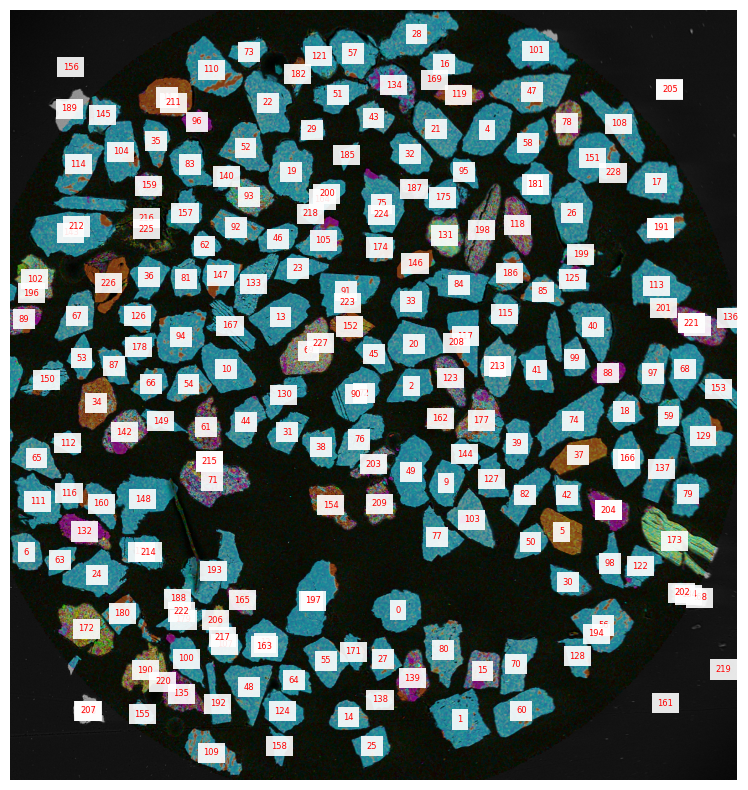

In [7]:
display_label_on_image(image, masks)

# Remove Replicate Labels or Labels with overlap

## Logic Cleaning

If there is replicate or overlapping, remove the one whose index is larger (lower confidence)

In [8]:
def check_overlap(mask1, mask2):
    # Create binary masks
    binary_mask1 = mask1['segmentation'].astype(bool)
    binary_mask2 = mask2['segmentation'].astype(bool)
    # Check if there is any overlap
    overlap = np.logical_and(binary_mask1, binary_mask2)
    return np.any(overlap)

def find_labels_to_remove(masks):
    labels_to_remove = set()
    num_masks = len(masks)

    for i in range(num_masks):
        if i in labels_to_remove:
            continue
        for j in range(i + 1, num_masks):
            if j in labels_to_remove:
                continue
            if check_overlap(masks[i], masks[j]):
                # Print the conflicting pair
                print(f"Conflict between mask {i} and mask {j}")

                # Keep the smaller label and remove the other
                if i < j:
                    labels_to_remove.add(j)
                else:
                    labels_to_remove.add(i)

    # Convert the set to a sorted list
    labels_to_remove = sorted(list(labels_to_remove))
    
    # Print the final list of labels to remove
    print(f"Labels to remove: {labels_to_remove}")
    
    return labels_to_remove


In [9]:
labels_to_remove = find_labels_to_remove(masks)

Conflict between mask 0 and mask 72
Conflict between mask 3 and mask 166
Conflict between mask 7 and mask 181
Conflict between mask 8 and mask 213
Conflict between mask 11 and mask 211
Conflict between mask 12 and mask 163
Conflict between mask 17 and mask 191
Conflict between mask 55 and mask 197
Conflict between mask 56 and mask 194
Conflict between mask 61 and mask 195
Conflict between mask 61 and mask 215
Conflict between mask 69 and mask 227
Conflict between mask 75 and mask 224
Conflict between mask 89 and mask 196
Conflict between mask 91 and mask 223
Conflict between mask 98 and mask 204
Conflict between mask 107 and mask 217
Conflict between mask 113 and mask 201
Conflict between mask 113 and mask 210
Conflict between mask 113 and mask 221
Conflict between mask 117 and mask 208
Conflict between mask 135 and mask 220
Conflict between mask 143 and mask 212
Conflict between mask 151 and mask 228
Conflict between mask 156 and mask 169
Conflict between mask 159 and mask 216
Conflic

Next step, you're going to leverage this list generated by logic filtering, and then start to do manual cleaning

In [ ]:
'''
    - Copy `labels_to_remove`, here goes to run `Click_unwanted_indexes_printout_list.py` . Copy and paste the `Indices of masks to be removed` from there to be used in  `filter_list`
    - Remember to change the image and json path there as well
'''

In [ ]:
"""
    You can iterate the above steop until a safisfactory index list to be removed
"""

In [18]:
iterated_index_to_be_removed = [189, 183, 72, 89, 136, 156, 161, 163, 166, 168, 169, 181, 191, 194, 195, 196, 197, 200, 201, 202, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228]

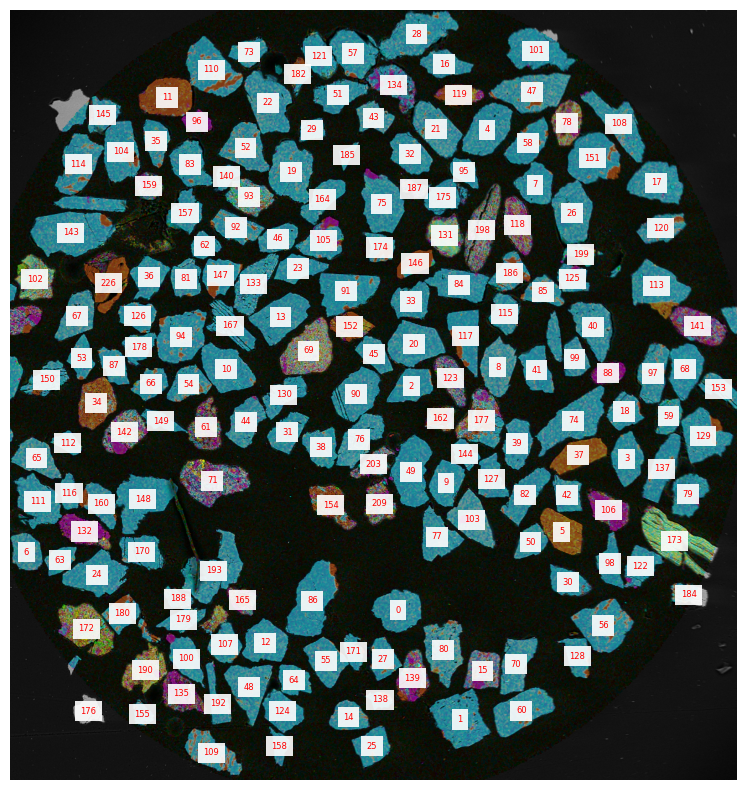

In [19]:
display_label_on_image(image, masks, filter_list=iterated_index_to_be_removed)

In [14]:
def display_binary_mask_and_overylay(image, masks, filter_list=None, image_2=None, overlay_color=(0, 255, 0), alpha=0.3):
    """
    Display 1) original image; 2) Binary mask; 3) original image with layered with the mask, mask's color is chosable

    Parameters:
    image (numpy array): The image to display.
    masks (list): The list of masks (dictionaries with 'segmentation' key).
    filter_list (list): List of indices to exclude from display (optional).
    image_2 (numpy array): The second image to overlay masks on (optional).
    overlay_color (tuple): The RGB color for the overlay (default is green).
    alpha (float): The transparency level of the overlay (default is 0.3).

    Returns:
    numpy array: The combined mask.
    """
    # Generate idx_list by enumerating each mask
    idx_list = list(range(len(masks)))

    # If filter_list is provided, filter out the indices that are in the filter_list
    if filter_list is not None:
        idx_list = [idx for idx in idx_list if idx not in filter_list]

    # Initialize a mask of zeros with the same size as the original image
    combined_mask = np.zeros_like(image[:,:,0], dtype=np.uint8)

    for idx, segmentation_entry in enumerate(masks):
        if idx in idx_list:  # Only consider masks in idx_list
            segmentation_mask = np.array(segmentation_entry['segmentation']).astype(np.uint8)
            # Combine the mask
            combined_mask = np.logical_or(combined_mask, segmentation_mask)

    # Convert combined_mask back to uint8 for visualization
    combined_mask = combined_mask.astype(np.uint8)

    # Create overlayed images
    overlayed_image = image.copy()
    
    if image_2 is not None:
        overlayed_image_2 = image_2.copy()
    
    # Create an overlay of the same size as the original image with the specified color
    color_overlay = np.zeros_like(image)
    color_overlay[combined_mask == 1] = overlay_color

    # Compute the alpha-blended images only in the regions specified by the mask
    overlayed_image[combined_mask == 1] = (color_overlay[combined_mask == 1] * alpha + 
                                           image[combined_mask == 1] * (1 - alpha)).astype(np.uint8)
    
    if image_2 is not None:
        overlayed_image_2[combined_mask == 1] = (color_overlay[combined_mask == 1] * alpha + 
                                                 image_2[combined_mask == 1] * (1 - alpha)).astype(np.uint8)

    plt.figure(figsize=(30,20))

    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Display the combined mask
    plt.subplot(2, 3, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('Combined Mask')
    plt.axis('off')

    # Display the overlayed images
    plt.subplot(2, 3, 3)
    plt.imshow(overlayed_image)
    plt.title('Overlayed on Original Image')
    plt.axis('off')

    if image_2 is not None:
        plt.subplot(2, 3, 4)
        plt.imshow(overlayed_image_2)
        plt.title('Overlayed on Image 2')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    return combined_mask

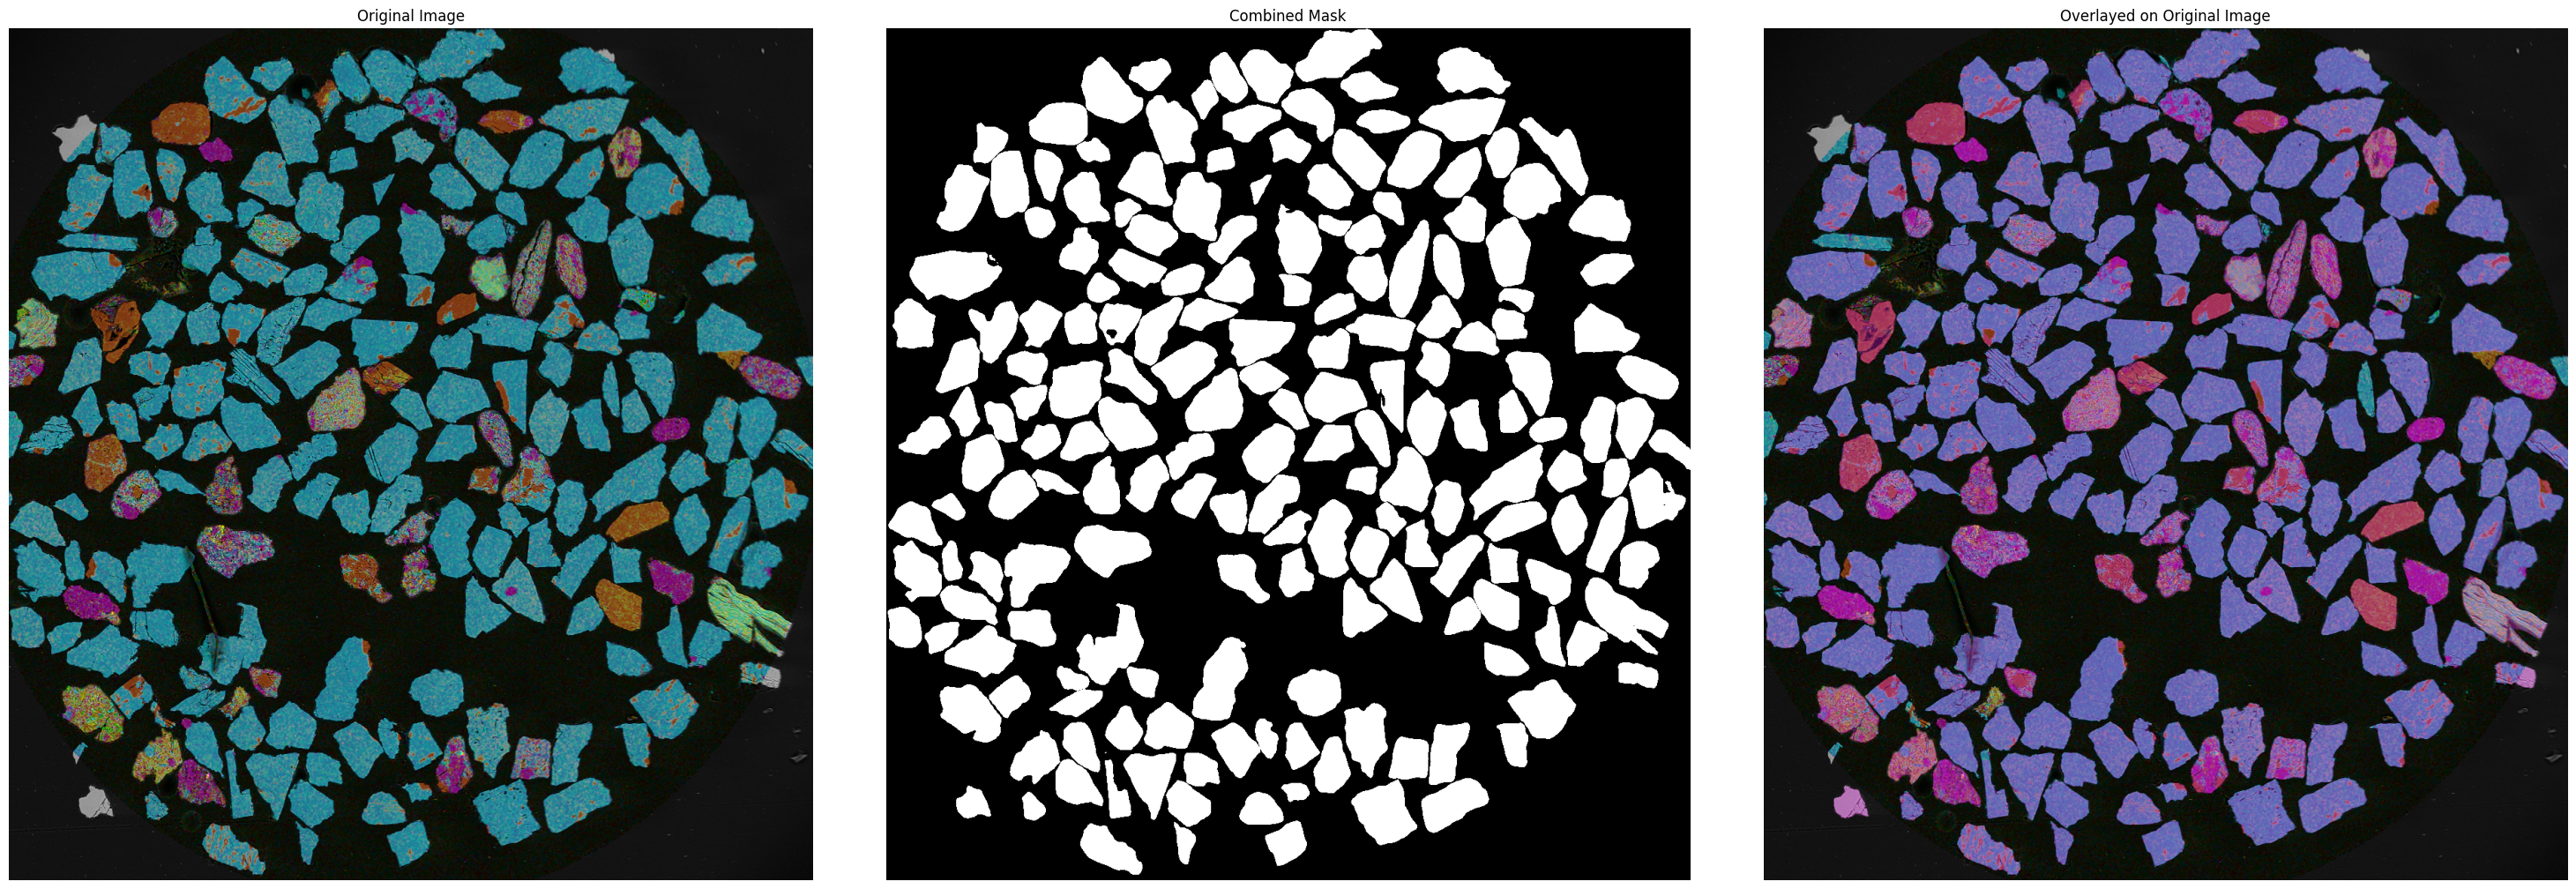

In [15]:
# image_K = cv2.imread(image_paths[1])
# image_K = cv2.cvtColor(image_K, cv2.COLOR_BGR2RGB)
# combined_mask = display_binary_mask_and_overylay(image_K, masks, filter_list=None, overlay_color=(253, 36, 255))
combined_mask = display_binary_mask_and_overylay(image, masks, filter_list=iterated_index_to_be_removed, overlay_color=(253, 36, 255))


In [ ]:
'''
    Here goes to run `Click_Image_Return_Index.py`
    Copy and paste index list you decided to remove.
    Therefore in the next python file you are going to run, these indexes won't distract your click to return the index
'''
'''
    Don't save another json file after data cleaning, just save the indexes list. Filter it or combine
    it when you need. Save another json file, when you import it. The idx of the new file won't match with
    the original file for the same mask.
'''